In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'
wcolors = ['blue', 'orange']

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

def clean(df):
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [2]:
# Velocita' media durante il giorno
def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore
    
def vmedia_week(df, mezzo):
    sd = 4
    weeks = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd, sd + 4)) |
            (df['Day'].between(sd + 7, sd + 7 + 4)) |
            (df['Day'].between(sd + 7*2, sd + 7*2 + 4)) |
            (df['Day'].between(sd + 7*3, sd + 7*3 + 4)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1, 1 + 4)) |
            (df['Day'].between(1 + 7, 1 + 7 + 4)) |
            (df['Day'].between(1 + 7*2, 1 + 7*2 + 4)) |
            (df['Day'].between(1 + 7*3, 1+7*3 + 4))))

    weekends = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd + 5, sd + 5 + 1)) |
            (df['Day'].between(sd + 7 + 5, sd + 7 + 5 + 1)) |
            (df['Day'].between(sd + 7*2 + 5, sd + 7*2 + 5 + 1)) |
            (df['Day'].between(sd + 7*3 + 5, sd + 7*3 + 5 + 1)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1 + 5, 1 + 5 + 1)) |
            (df['Day'].between(1 + 7 + 5, 1 + 7 + 5 + 1)) |
            (df['Day'].between(1 + 7*2 + 5, 1 + 7*2 + 5 + 1)) |
            (df['Day'].between(1 + 7*3 + 5, 1 + 7*3 + 5 + 1))))
    
    lst = [
        vmedia_giorno(df[weeks], mezzo),
        vmedia_giorno(df[weekends], mezzo)]
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=['Lun-Ven', 'Sab-Dom']).round(2)

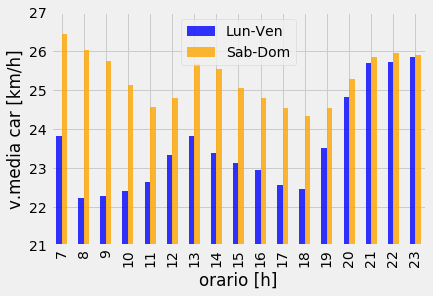

In [3]:
tragitti = tragitti[clean(tragitti)]
vmedia_week(tragitti, 'Car').plot.bar(color=wcolors, alpha=.8)
plt.ylim(21, 27)
plt.xlabel('orario [h]')
plt.ylabel('v.media car [km/h]')
plt.show()

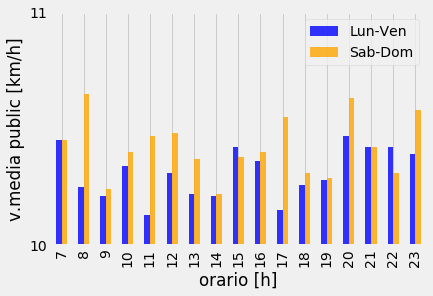

In [4]:
vmedia_week(tragitti, 'Public').plot.bar(color=wcolors, alpha=.8)
plt.ylim(10, 11)
plt.yticks(range(10, 12, 1))
plt.xlabel('orario [h]')
plt.ylabel('v.media public [km/h]')
plt.show()

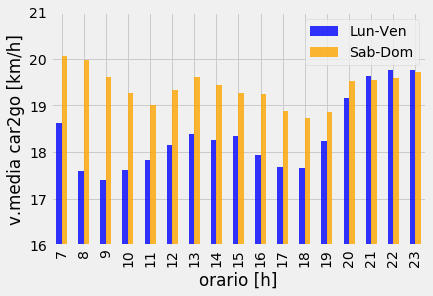

In [5]:
vmedia_week(tragitti, 'Car2Go').plot.bar(color=wcolors, alpha=.8)
plt.ylim(16, 21)
plt.xlabel('orario [h]')
plt.ylabel('v.media car2go [km/h]')
plt.show()

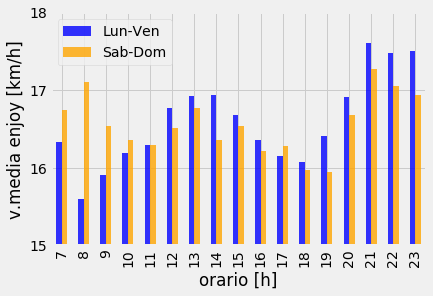

In [6]:
vmedia_week(tragitti, 'Enjoy').plot.bar(color=wcolors, alpha=.8)
plt.ylim(15, 18)
plt.yticks(range(15, 19, 1))
plt.xlabel('orario [h]')
plt.ylabel('v.media enjoy [km/h]')
plt.show()

In [7]:
def anova(groups):
    all_elements = pd.concat(groups)
    
    sum_total = sum((all_elements - all_elements.mean())**2)
    sum_within = sum([sum((g - g.mean())**2) for g in groups])
    
    sum_between = sum([len(g) * (g.mean()-all_elements.mean())**2 for g in groups])
    assert(np.abs(sum_total - sum_within - sum_between) < 10**-5)
    n = len(all_elements)
    total_var = sum_total / float(n-1)
    within_var = sum_within / float(n-len(groups))
    
    return (total_var, within_var*(n-len(groups))/(n-1))

In [8]:
def list_of_list(df):
    l = []
    for h in range(7, 24):
        l.append(df[df['Hour'] == h]['CDistance'])
    return l

In [9]:
anova(list_of_list(tragitti))

(3.0885379431716418, 3.0873511580132087)

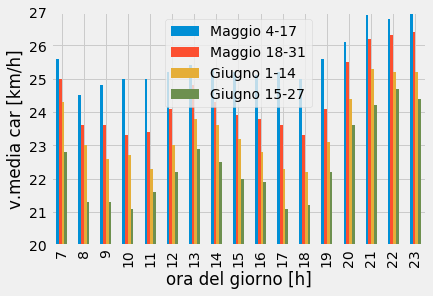

In [10]:
lst = [
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Car'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Car'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Car'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Car')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot.bar()
plt.ylim(20, 27)
plt.xlabel('ora del giorno [h]')
plt.ylabel('v.media car [km/h]')
plt.show()

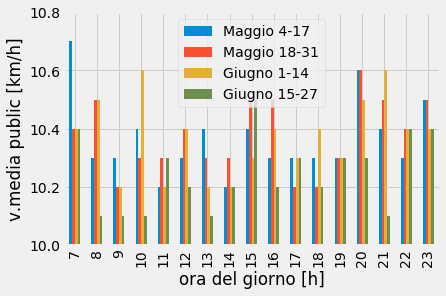

In [11]:
lst = [
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Public'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Public'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Public'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Public')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot.bar()
plt.ylim(10, 10.8)
plt.xlabel('ora del giorno [h]')
plt.ylabel('v.media public [km/h]')
plt.show()

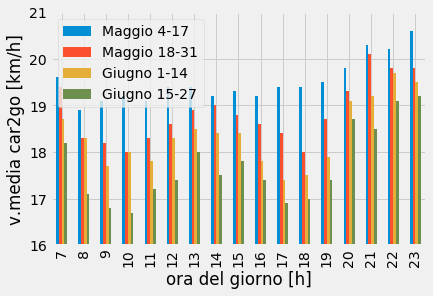

In [12]:
lst = [
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Car2Go'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Car2Go'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Car2Go'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Car2Go')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot.bar()
plt.ylim(16, 21)
plt.xlabel('ora del giorno [h]')
plt.ylabel('v.media car2go [km/h]')
plt.show()

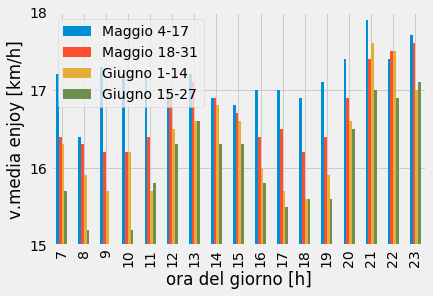

In [13]:
lst = [
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Enjoy'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Enjoy'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Enjoy'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Enjoy')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot.bar()
plt.ylim(15, 18)
plt.yticks(range(15, 19, 1))
plt.xlabel('ora del giorno [h]')
plt.ylabel('v.media enjoy [km/h]')
plt.show()